In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from array import array
import json
import math

In [2]:
def plot_img_histogram(img):
    bins = np.zeros(256, dtype=int)
    for l in img.flatten():
        bins[int(l)] += 1

    plt.bar(list(range(bins.shape[0])), bins)
    plt.show()

In [3]:
def psicovisual_compression(img, ratio=4):
    return np.round((img_data + 1) / ratio) * ratio - 1

def huffman_encoding(img):
    values, count = np.unique(img, return_counts=True)
    probabilities = []
    codes = {}
    
    for v, c in zip(values, count):
        codes[int(v)] = ""
        probabilities.append({ "s": [int(v)], "p": c })
    
    while len(probabilities) > 1:
        probabilities.sort(key=lambda x: x["p"], reverse=True)
        
        for v in probabilities[-1]["s"]: codes[v] = "0" + codes[v]
        for v in probabilities[-2]["s"]: codes[v] = "1" + codes[v]
        
        probabilities[-2]["s"] += probabilities[-1]["s"]
        probabilities[-2]["p"] += probabilities[-1]["p"]
        probabilities.pop()
        
    all_bits = ""
    for v in img.flatten():
        all_bits += codes[int(v)]
    
    inv_codes = {v: k for k, v in codes.items()}
    
    out_bytes = int(all_bits, 2).to_bytes(math.ceil(len(all_bits) / 8), byteorder='big')
    return out_bytes, inv_codes, img.shape

def huffman_decoding(img_code, codes, shape):
    image_values = []
    buffer = ""
    for c in img_code:
        buffer += str(c)
        if buffer in codes:
            image_values.append(codes[buffer])
            buffer = ""
    
    image_values = np.array(image_values)
    image_values = np.reshape(image_values, shape)
    return image_values

def create_bits_from_header(codes, shape):   
    codes["w"] = shape[0]
    codes["h"] = shape[1]
    return json.dumps(codes).encode('utf-8')

def get_data_from_bytes(bytes_seq):
    header_bytes = all_bytes.split(b"}")[0] + b"}"
    code_bytes = all_bytes[len(header_bytes):]

    header = json.loads(header_bytes)

    code_int = [int.from_bytes([c], byteorder='big') for c in code_bytes]
    code = []
    for ci in code_int:
        code += [int(x) for x in '{:08b}'.format(ci)]
    code = code[7:]
    return code, header, (header["w"], header["h"])

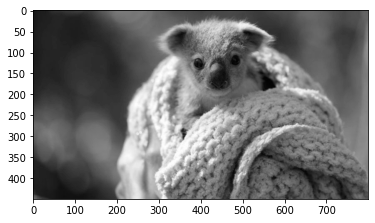

Bytes: 360000


In [4]:
image = Image.open("koala.jpeg").convert('L')

img_data = np.asarray(image)

plt.imshow(image, cmap='gray')
plt.show()

orig_bytes = img_data.nbytes
print("Bytes:", orig_bytes)

In [5]:
huf, codes, shape = huffman_encoding(img_data)

with open("test.bin", "wb") as f:
    f.write(create_bits_from_header(codes, shape))
    f.write(huf)

In [6]:
f = open("test.bin", "rb")
all_bytes = f.read()
code, header, shape = get_data_from_bytes(all_bytes)

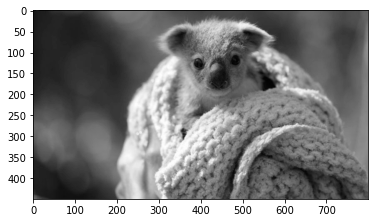

Bytes: 350184


In [8]:
img_decoded = huffman_decoding(code, header, shape)

plt.imshow(img_decoded, cmap='gray')
plt.show()

compr_bytes = len(all_bytes)
print("Bytes:", compr_bytes)

In [11]:
print("Improvement:", compr_bytes / orig_bytes)

Improvement: 0.9727333333333333
